In [53]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
sys.path.append(os.path.abspath('..'))


from log_processing import process_log, from_csv

In [59]:
round = 1
day = 0

activities, trades = from_csv(round, day, dir="../../data")


<Axes: >

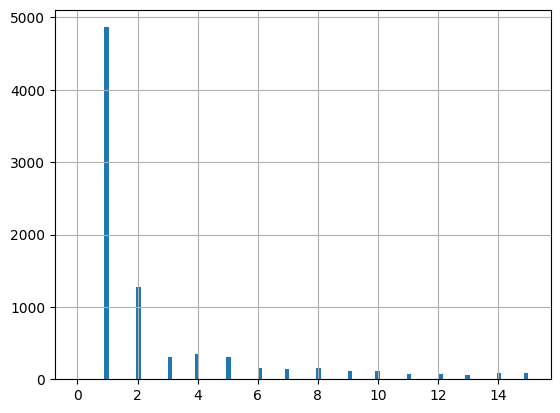

In [ ]:
trades["quantity"].hist(bins=100)

In [ ]:
# Convert to pandas Series if it's not already
price_series = pd.Series(price)

window_short = 10
window_long = 20

# Calculate Simple Moving Averages with different window sizes
sma_short = price_series.rolling(window=window_short).mean()
sma_long = price_series.rolling(window=window_long).mean()


# Create signals based on SMA crossovers
signals = pd.DataFrame(index=price_series.index)

signals['price'] = price_series
signals['short_ma'] = sma_short
signals['long_ma'] = sma_long
signals['signal'] = 0.0

# Create buy/sell signals when short MA crosses long MA
signals['signal'][window_short:] = np.where(signals['short_ma'][window_short:] > signals['long_ma'][window_short:], 1.0, 0.0)
signals['positions'] = signals['signal'].diff()

# Plot signals
plt.figure(figsize=(16, 8))
plt.plot(price_series, label='Price', alpha=0.5)
plt.plot(signals['short_ma'], label='Short MA')
plt.plot(signals['long_ma'], label='Long MA')

# Plot buy signals
plt.plot(signals.loc[signals['positions'] == 1.0].index, 
         signals.loc[signals['positions'] == 1.0]['short_ma'],
         '^', markersize=10, color='g', label='Buy Signal')

# Plot sell signals
plt.plot(signals.loc[signals['positions'] == -1.0].index, 
         signals.loc[signals['positions'] == -1.0]['short_ma'],
         'v', markersize=10, color='r', label='Sell Signal')

plt.legend()
plt.title('Moving Average Crossover Signals')
plt.xlabel('Time')
plt.xlim([0, 400])
plt.ylabel('Price')
plt.grid(True, alpha=0.3)
plt.show()
